In [1]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import cartopy.mpl.ticker as cticker
import matplotlib.ticker as mticker

import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis
import cmocean as cmo
import mtspec
import csv 
# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
from defs import difmodel
import scipy
from defs import lon180, makedz,regularAtlmask
from matplotlib.gridspec import GridSpec
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import cartopy.mpl.ticker as cticker
import matplotlib.ticker as mticker


In [2]:
folder = '/Volumes/External/DataPlioMIP2/Data/Processed/'
modellist =  ['GISS2.1G', 'EC-Earth3-LR',  'CCSM4-UoT', 'CCSM4-Utr','CCSM4', 'CESM1.2', 'CESM2', 'IPSL-CM5A', 'IPSL-CM5A2','IPSL-CM6A','MIROC4m','COSMOS', 'HadCM3', 'NorESM1-F','HadGEM3']

In [3]:
##Create array that contains all 1x1 interpolated velocity fields for E280 and Eoi400, averaged over the top 500 m
model = 'CESM1.2'
ds = xr.open_dataset(folder+model+'/Eoi400/'+'SST_annual_100yr.nc')
ds = lon180(ds)

dsE280 = xr.Dataset(data_vars = dict(vo=(["model","lat","lon"], np.zeros([len(modellist), len(ds.lat), len(ds.lon)]))), coords = dict(model = modellist, lat = ds.lat.values, lon = ds.lon.values))
dsEoi400 = dsE280.copy(deep=True)

for i in range(len(modellist)):
    model = modellist[i]
    ds1 = xr.open_dataset(folder+model+'/E280/'+'vo_1x1_100yr.nc')
    ds1 = lon180(ds1)
    dsE280.vo[i] = ds1.vo.where(ds1.z<500).weighted(makedz(ds1)).mean(dim='z')
    
    ds1 = lon180(xr.open_dataset(folder+model+'/Eoi400/'+'vo_1x1_100yr.nc'))
    dsEoi400.vo[i] = ds1.vo.where(ds1.z<500).weighted(makedz(ds1)).mean(dim='z')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/regionmask/core/plot.py:12: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  coords += [np.asarray(p.exterior)[:, :2]] + [


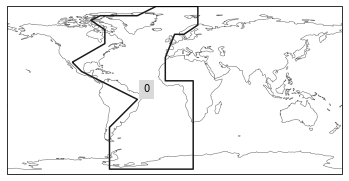

In [4]:
#Create Atlantic mask to exclude points in Mediterranean and North Sea
import regionmask
model = 'CCSM4'
Atlantic = np.array([[-110,30],[-75,50],[-75, 65],[-90,75],[-80,80],[-40,80], [-20,90], [25,90], [25,80], [25,70],[10,60],[0,60],[-10,35], [-10,10], [20,10], [20,-34],[20,-85],[-70,-85], [-70,-40], [-40, -10], [-70,5], [-100,20]])
region = regionmask.Regions([Atlantic])

ax = region.plot()
ax.set_extent([0, 350, -90, 90], crs=ccrs.PlateCarree())

# define lat/ lon grid
ds = xr.open_dataset(folder+model+'/Eoi400/'+'SST_annual_100yr.nc')
ds = lon180(ds)

mask_Atl_reg = region.mask(ds.lon.values, ds.lat.values)

In [5]:
vgyreE280 = dsE280.vo.where(dsE280.vo.count(dim='model')>10).where(mask_Atl_reg>-1) #Only where >10 models have ocean grid cells
vgyreEoi400 = dsEoi400.vo.where(dsEoi400.vo.count(dim='model')>10).where(mask_Atl_reg>-1) #Only where >10 models have ocean grid cells

#Weighting for latitudinal averaging
weights = np.cos(np.deg2rad(vgyreE280.lat))
weights.name = "weights"

#Select only the subtropical gyre region between 20-40N
#take meridionally averaged meridional velocity (which has already been averaged over top 500 m)
mmmE280 = vgyreE280[:-1].mean(dim='model').where(vgyreE280.lon<0).where(vgyreE280.lon>-90).where(vgyreE280.lat>20).where(vgyreE280.lat<40).weighted(weights).mean(dim='lat')
mmmEoi400 = vgyreEoi400[:-1].mean(dim='model').where(vgyreE280.lon<0).where(vgyreE280.lon>-90).where(vgyreE280.lat>20).where(vgyreE280.lat<40).weighted(weights).mean(dim='lat')

std = ((vgyreEoi400[:-1]-vgyreE280[:-1]).where(vgyreE280.lon<0).where(vgyreE280.lon>-90).where(vgyreE280.lat>20).where(vgyreE280.lat<40).weighted(weights).mean(dim='lat')).std(dim='model')

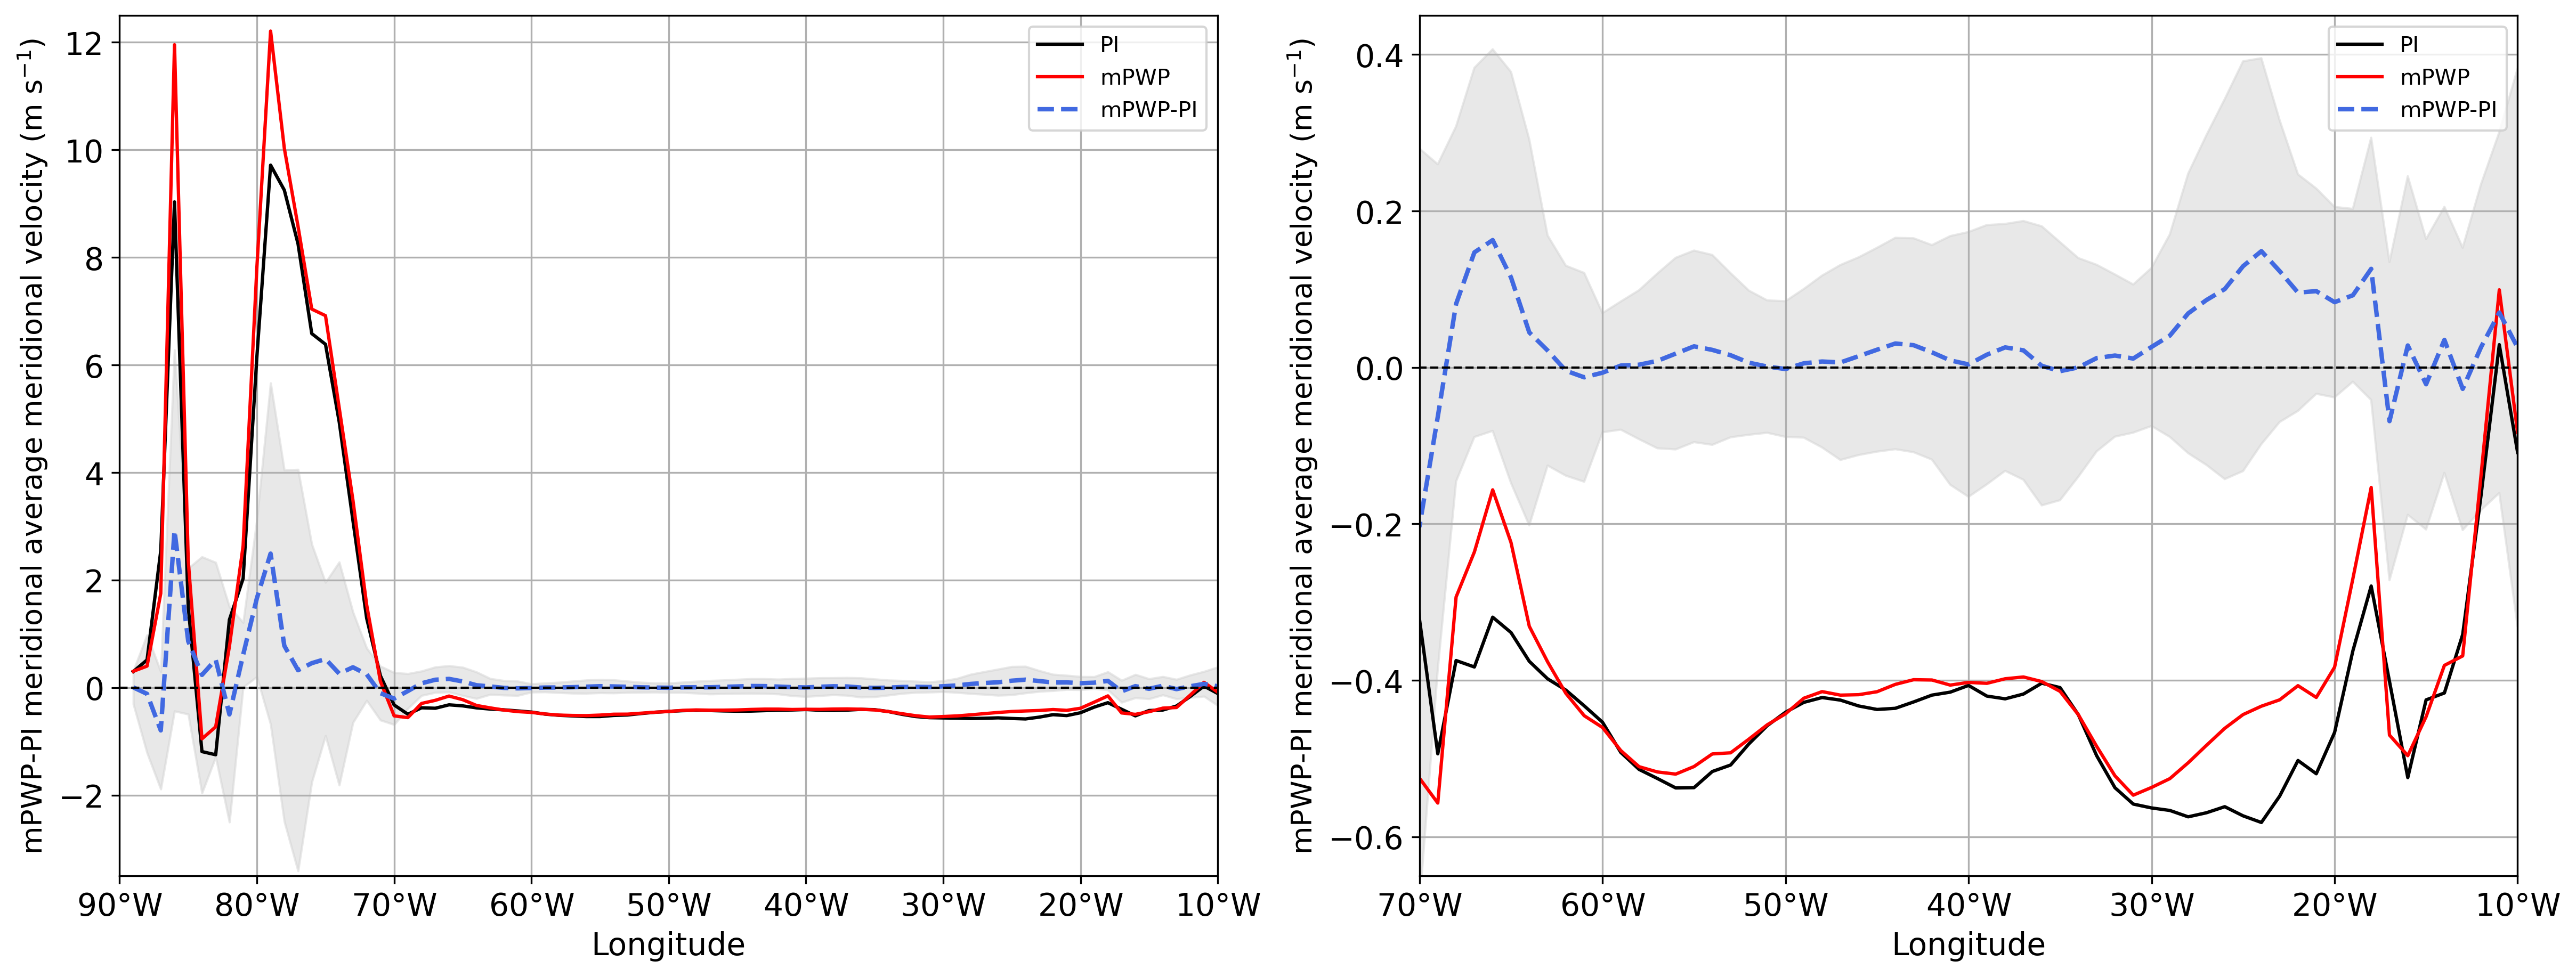

In [6]:
x_pos = np.array([-90, -80, -70, -60, -50, -40, -30, -20, -10])
xtext = ('90$\degree$W', '80$\degree$W','70$\degree$W', '60$\degree$W', '50$\degree$W', '40$\degree$W', '30$\degree$W', '20$\degree$W', '10$\degree$W')

x_pos1 = np.array([-70, -60, -50, -40, -30, -20, -10])
xtext1 = ('70$\degree$W', '60$\degree$W', '50$\degree$W', '40$\degree$W', '30$\degree$W', '20$\degree$W', '10$\degree$W')

plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.rcParams['axes.labelsize'] = 14

fig1 = plt.subplots(figsize=(16,6), constrained_layout=True, dpi=300)

ax2 = plt.subplot(121)
plt.plot(mmmE280.lon, mmmE280, color='black',linewidth = 1.5, label='PI')
plt.plot(mmmE280.lon, mmmEoi400, color='red',linewidth = 1.5, label='mPWP')
plt.plot(mmmE280.lon, mmmEoi400-mmmE280, color='royalblue',linewidth = 2,linestyle='--', label='mPWP-PI')
ax2.fill_between(mmmE280.lon, (mmmEoi400-mmmE280)-std, (mmmEoi400-mmmE280)+std, color='lightgrey', alpha=0.5)
plt.plot([-90,0],[0,0],linestyle='--', color='k', linewidth=1)
ax2.set_xlim([-90,-10])
ax2.set_ylim([-3.5,12.5])
ax2.legend()
#ax2.set_ylim([1.75,3.4])
ax2.grid()
ax2.set_xticks(x_pos)
ax2.set_xticklabels(xtext)
ax2.set_xlabel('Longitude', fontsize=14)
ax2.set_ylabel('mPWP-PI meridional average meridional velocity (m s$^{-1}$)', fontsize=13)

ax2 = plt.subplot(122)
plt.plot(mmmE280.lon, mmmE280, color='black',linewidth = 1.5, label='PI')
plt.plot(mmmE280.lon, mmmEoi400, color='red',linewidth = 1.5, label='mPWP')
plt.plot(mmmE280.lon, mmmEoi400-mmmE280, color='royalblue',linestyle='--',linewidth = 2, label='mPWP-PI')
ax2.fill_between(mmmE280.lon, (mmmEoi400-mmmE280)-std, (mmmEoi400-mmmE280)+std, color='lightgrey', alpha=0.5)
plt.plot([-90,0],[0,0],linestyle='--', color='k', linewidth=1)
ax2.set_xlim([-70,-10])
ax2.set_ylim([-0.65,0.45])
ax2.grid()
ax2.legend()
ax2.set_xticks(x_pos1)
ax2.set_xticklabels(xtext1)
ax2.set_xlabel('Longitude', fontsize=14)
ax2.set_ylabel('mPWP-PI meridional average meridional velocity (m s$^{-1}$)', fontsize=13)
plt.savefig('figs10.png', bbox_inches='tight')